In [12]:
# -------------------------------
# 1. Работа с таблицами и числовыми данными
# -------------------------------
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


# -------------------------------
# 2. Машинное обучение
# -------------------------------
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Для балансировки классов
from imblearn.over_sampling import SMOTE

# -------------------------------
# 3. Визуализация и отчёты
# -------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# -------------------------------
# 4. Интерпретация модели
# -------------------------------
import shap
from lime.lime_tabular import LimeTabularExplainer

# -------------------------------
# 5. Опционально: работа с Excel / Parquet
# -------------------------------
import openpyxl
import pyarrow

In [14]:
df = pd.read_csv('data/synthetic_bank_2000.csv')
df = df.drop(columns=['Примечание'])
df.head()

,Дата проводки,Счёт (наименование + ИНН),Сумма по дебету (RUB),Сумма по кредиту (RUB),Банк (условный БИК + наименование),Назначение платежа (детали),Риск,Причины_оценки_риска
0,2025-08-01 08:09:36,"ООО ТРАНСЛАЙН, ИНН: 1322002203","263,316.77",NaN,"Россельхозбанк, г. Москва (БИК: 044525100)",Оплата по договор №392/2025 от 01.06.2025; сче...,Низкий,supplier_with_docs_amount_ok
1,2025-08-01 08:42:55,"ИП СИДОРОВ В.П., ИНН: 6606007006",NaN,"85,912.24","Россельхозбанк, г. Москва (БИК: 044525100)","Перечисление заработной платы, период: 08.2025...",Низкий,default_low
2,2025-08-01 09:10:22,"ООО БЛЭКХОЛД, ИНН: 2029002900","36,635.96",NaN,"ВТБ, г. Москва, Головной офис (БИК: 040349700)",Оплата по договор №798/2025 от 17.06.2025; сче...,Низкий,supplier_with_docs_amount_ok
3,2025-08-01 09:39:30,"ООО НЕОТЕК, ИНН: 1120002001",NaN,"349,265.15","Промсвязьбанк, г. Москва (БИК: 044525000)",Оплата по договор №184/2025 от 23.07.2025; сче...,Низкий,supplier_with_docs_amount_ok
4,2025-08-01 10:13:15,"ООО ПРОВАЙДЕР, ИНН: 2635003506",NaN,"49,218.76","Альфа-Банк, г. Москва (БИК: 044030653)",Оплата коммунальных услуг и интернет; период: ...,Без риска,utilities_or_salary_small


In [17]:
len(df)

2000

In [18]:
df.columns

Index(['Дата проводки', 'Счёт (наименование + ИНН)', 'Сумма по дебету (RUB)',
       'Сумма по кредиту (RUB)', 'Банк (условный БИК + наименование)',
       'Назначение платежа (детали)', 'Риск', 'Причины_оценки_риска'],
      dtype='object')

In [22]:
print('Пустые значения в колонке "Назначение платежа": ', df['Назначение платежа (детали)'].isna().sum())
print('Пустые значени в колонке "Банк": ', df['Банк (условный БИК + наименование)'].isna().sum())
print('Пустые значения в колонке "Счет": ', df['Счёт (наименование + ИНН)'].isna().sum())
print('Пустые значения в колонке "Дата провдки": ', df['Дата проводки'].isna().sum())

Пустые значения в колонке "Назначение платежа":  0
Пустые значени в колонке "Банк":  0
Пустые значения в колонке "Счет":  0
Пустые значения в колонке "Дата провдки":  0


In [24]:
import re
# Колонка с наименованием и ИНН
col = "Счёт (наименование + ИНН)"

# Список типов юр. лиц (можно расширить при необходимости)
entity_types = [
    "ИП", "ООО", "ОАО", "АО", "ПАО", "НАО", "НКО",
    "Фонд", "Кооператив", "Ассоциация", "ТСЖ", "Общество"
]

# Функция для извлечения типа из строки
def get_entity_type(name):
    for et in entity_types:
        if re.search(rf"\b{et}\b", name):
            return et
    return "Другое"

# Применяем к колонке
df["entity_type"] = df[col].apply(get_entity_type)

# Считаем количество каждого типа
counts = df["entity_type"].value_counts()
print(counts)

entity_type
ООО    1603
ИП      397
Name: count, dtype: int64


In [25]:
df.head()

,Дата проводки,Счёт (наименование + ИНН),Сумма по дебету (RUB),Сумма по кредиту (RUB),Банк (условный БИК + наименование),Назначение платежа (детали),Риск,Причины_оценки_риска,entity_type
0,2025-08-01 08:09:36,"ООО ТРАНСЛАЙН, ИНН: 1322002203","263,316.77",NaN,"Россельхозбанк, г. Москва (БИК: 044525100)",Оплата по договор №392/2025 от 01.06.2025; сче...,Низкий,supplier_with_docs_amount_ok,ООО
1,2025-08-01 08:42:55,"ИП СИДОРОВ В.П., ИНН: 6606007006",NaN,"85,912.24","Россельхозбанк, г. Москва (БИК: 044525100)","Перечисление заработной платы, период: 08.2025...",Низкий,default_low,ИП
2,2025-08-01 09:10:22,"ООО БЛЭКХОЛД, ИНН: 2029002900","36,635.96",NaN,"ВТБ, г. Москва, Головной офис (БИК: 040349700)",Оплата по договор №798/2025 от 17.06.2025; сче...,Низкий,supplier_with_docs_amount_ok,ООО
3,2025-08-01 09:39:30,"ООО НЕОТЕК, ИНН: 1120002001",NaN,"349,265.15","Промсвязьбанк, г. Москва (БИК: 044525000)",Оплата по договор №184/2025 от 23.07.2025; сче...,Низкий,supplier_with_docs_amount_ok,ООО
4,2025-08-01 10:13:15,"ООО ПРОВАЙДЕР, ИНН: 2635003506",NaN,"49,218.76","Альфа-Банк, г. Москва (БИК: 044030653)",Оплата коммунальных услуг и интернет; период: ...,Без риска,utilities_or_salary_small,ООО


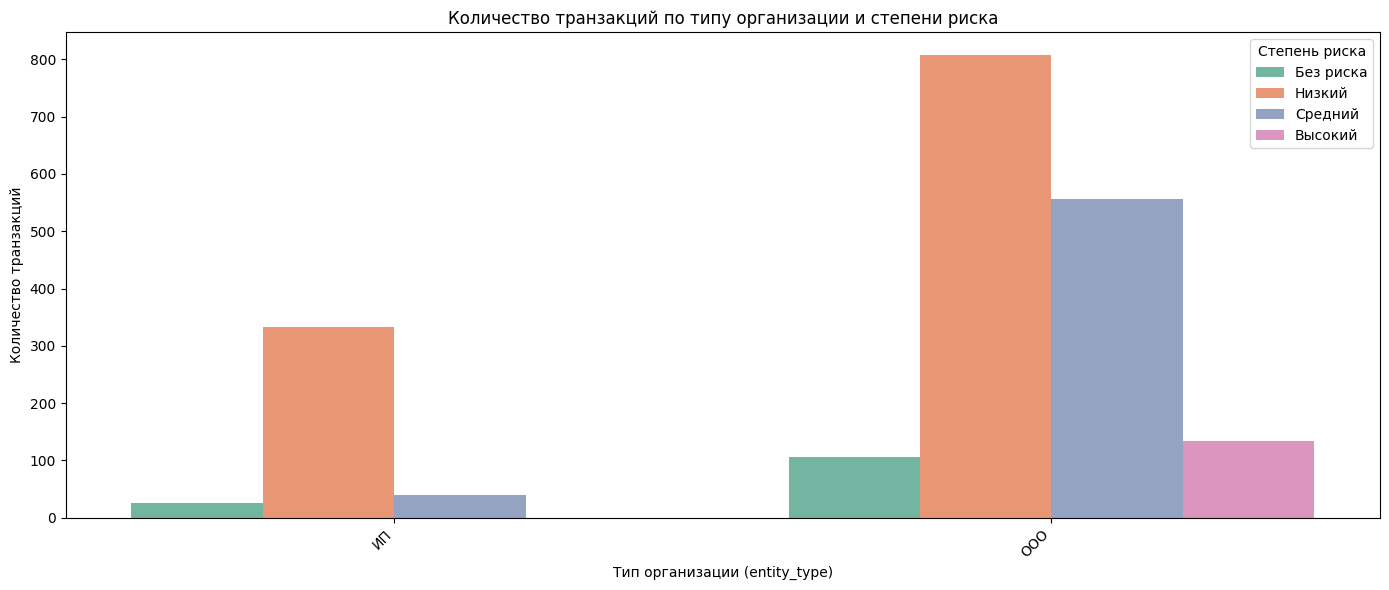

In [27]:
pivot = df.groupby(["entity_type", "Риск"]).size().reset_index(name="count")

# Рисуем группированный столбчатый график
plt.figure(figsize=(14,6))
sns.barplot(data=pivot, x="entity_type", y="count", hue="Риск", palette="Set2")

plt.title("Количество транзакций по типу организации и степени риска")
plt.xlabel("Тип организации (entity_type)")
plt.ylabel("Количество транзакций")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Степень риска")
plt.tight_layout()
plt.show()

In [28]:
df["Сумма по дебету (RUB)"] = df["Сумма по дебету (RUB)"].replace(',', '', regex=True)
df["Сумма по дебету (RUB)"] = pd.to_numeric(df["Сумма по дебету (RUB)"], errors='coerce')

# Функция для определения группы
def debit_group(amount):
    if pd.isna(amount):
        return 0  # NaN → группа 0
    elif amount < 50_000:
        return 1
    elif amount < 500_000:
        return 2
    elif amount < 5_000_000:
        return 3
    elif amount < 20_000_000:
        return 4
    else:
        return 5 

# Применяем функцию
df["debit_group"] = df["Сумма по дебету (RUB)"].apply(debit_group)

df.head()

,Дата проводки,Счёт (наименование + ИНН),Сумма по дебету (RUB),Сумма по кредиту (RUB),Банк (условный БИК + наименование),Назначение платежа (детали),Риск,Причины_оценки_риска,entity_type,debit_group
0,2025-08-01 08:09:36,"ООО ТРАНСЛАЙН, ИНН: 1322002203",263316.77,NaN,"Россельхозбанк, г. Москва (БИК: 044525100)",Оплата по договор №392/2025 от 01.06.2025; сче...,Низкий,supplier_with_docs_amount_ok,ООО,2
1,2025-08-01 08:42:55,"ИП СИДОРОВ В.П., ИНН: 6606007006",NaN,"85,912.24","Россельхозбанк, г. Москва (БИК: 044525100)","Перечисление заработной платы, период: 08.2025...",Низкий,default_low,ИП,0
2,2025-08-01 09:10:22,"ООО БЛЭКХОЛД, ИНН: 2029002900",36635.96,NaN,"ВТБ, г. Москва, Головной офис (БИК: 040349700)",Оплата по договор №798/2025 от 17.06.2025; сче...,Низкий,supplier_with_docs_amount_ok,ООО,1
3,2025-08-01 09:39:30,"ООО НЕОТЕК, ИНН: 1120002001",NaN,"349,265.15","Промсвязьбанк, г. Москва (БИК: 044525000)",Оплата по договор №184/2025 от 23.07.2025; сче...,Низкий,supplier_with_docs_amount_ok,ООО,0
4,2025-08-01 10:13:15,"ООО ПРОВАЙДЕР, ИНН: 2635003506",NaN,"49,218.76","Альфа-Банк, г. Москва (БИК: 044030653)",Оплата коммунальных услуг и интернет; период: ...,Без риска,utilities_or_salary_small,ООО,0


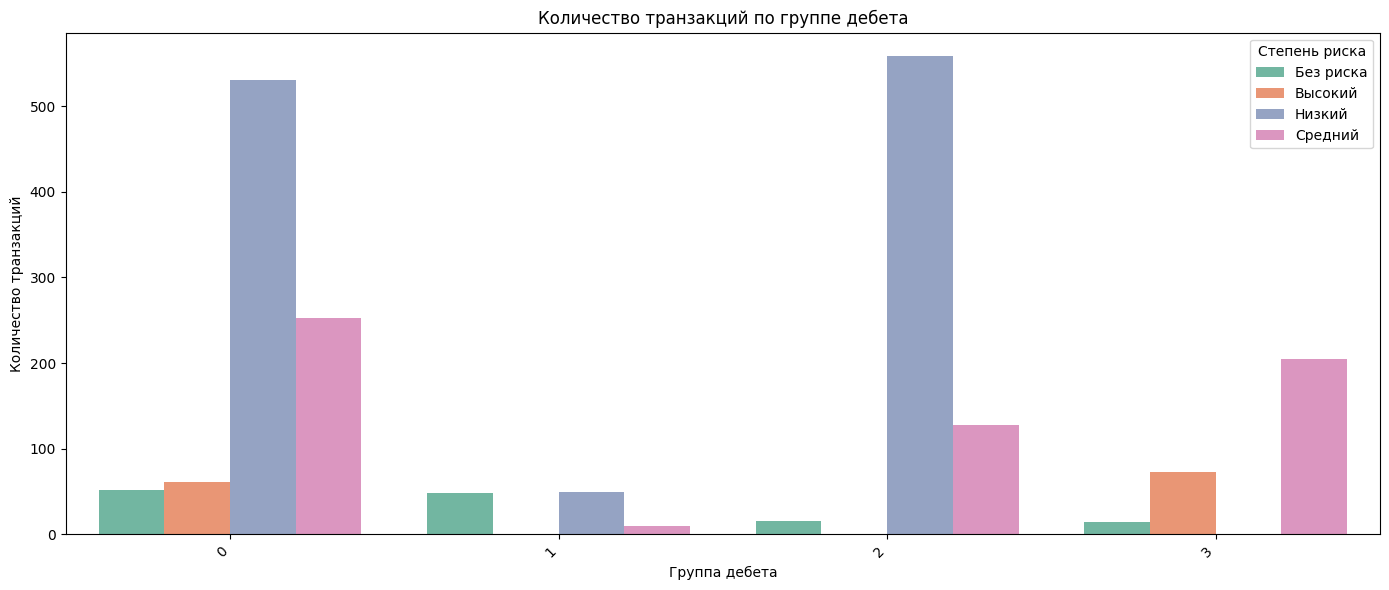

In [29]:
pivot = df.groupby(["debit_group", "Риск"]).size().reset_index(name="count")

# Рисуем группированный столбчатый график
plt.figure(figsize=(14,6))
sns.barplot(data=pivot, x="debit_group", y="count", hue="Риск", palette="Set2")

plt.title("Количество транзакций по группе дебета")
plt.xlabel("Группа дебета")
plt.ylabel("Количество транзакций")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Степень риска")
plt.tight_layout()
plt.show()

In [30]:
df["Сумма по кредиту (RUB)"] = df["Сумма по кредиту (RUB)"].replace(',', '', regex=True)
df["Сумма по кредиту (RUB)"] = pd.to_numeric(df["Сумма по кредиту (RUB)"], errors='coerce')

# Функция для определения группы
def debit_group(amount):
    if pd.isna(amount):
        return 0  # NaN → группа 0
    elif amount < 50_000:
        return 1
    elif amount < 500_000:
        return 2
    elif amount < 5_000_000:
        return 3
    elif amount < 20_000_000:
        return 4
    else:
        return 5  

# Применяем функцию
df["credit_group"] = df["Сумма по кредиту (RUB)"].apply(debit_group)

df.head()

,Дата проводки,Счёт (наименование + ИНН),Сумма по дебету (RUB),Сумма по кредиту (RUB),Банк (условный БИК + наименование),Назначение платежа (детали),Риск,Причины_оценки_риска,entity_type,debit_group,credit_group
0,2025-08-01 08:09:36,"ООО ТРАНСЛАЙН, ИНН: 1322002203",263316.77,NaN,"Россельхозбанк, г. Москва (БИК: 044525100)",Оплата по договор №392/2025 от 01.06.2025; сче...,Низкий,supplier_with_docs_amount_ok,ООО,2,0
1,2025-08-01 08:42:55,"ИП СИДОРОВ В.П., ИНН: 6606007006",NaN,85912.24,"Россельхозбанк, г. Москва (БИК: 044525100)","Перечисление заработной платы, период: 08.2025...",Низкий,default_low,ИП,0,2
2,2025-08-01 09:10:22,"ООО БЛЭКХОЛД, ИНН: 2029002900",36635.96,NaN,"ВТБ, г. Москва, Головной офис (БИК: 040349700)",Оплата по договор №798/2025 от 17.06.2025; сче...,Низкий,supplier_with_docs_amount_ok,ООО,1,0
3,2025-08-01 09:39:30,"ООО НЕОТЕК, ИНН: 1120002001",NaN,349265.15,"Промсвязьбанк, г. Москва (БИК: 044525000)",Оплата по договор №184/2025 от 23.07.2025; сче...,Низкий,supplier_with_docs_amount_ok,ООО,0,2
4,2025-08-01 10:13:15,"ООО ПРОВАЙДЕР, ИНН: 2635003506",NaN,49218.76,"Альфа-Банк, г. Москва (БИК: 044030653)",Оплата коммунальных услуг и интернет; период: ...,Без риска,utilities_or_salary_small,ООО,0,1


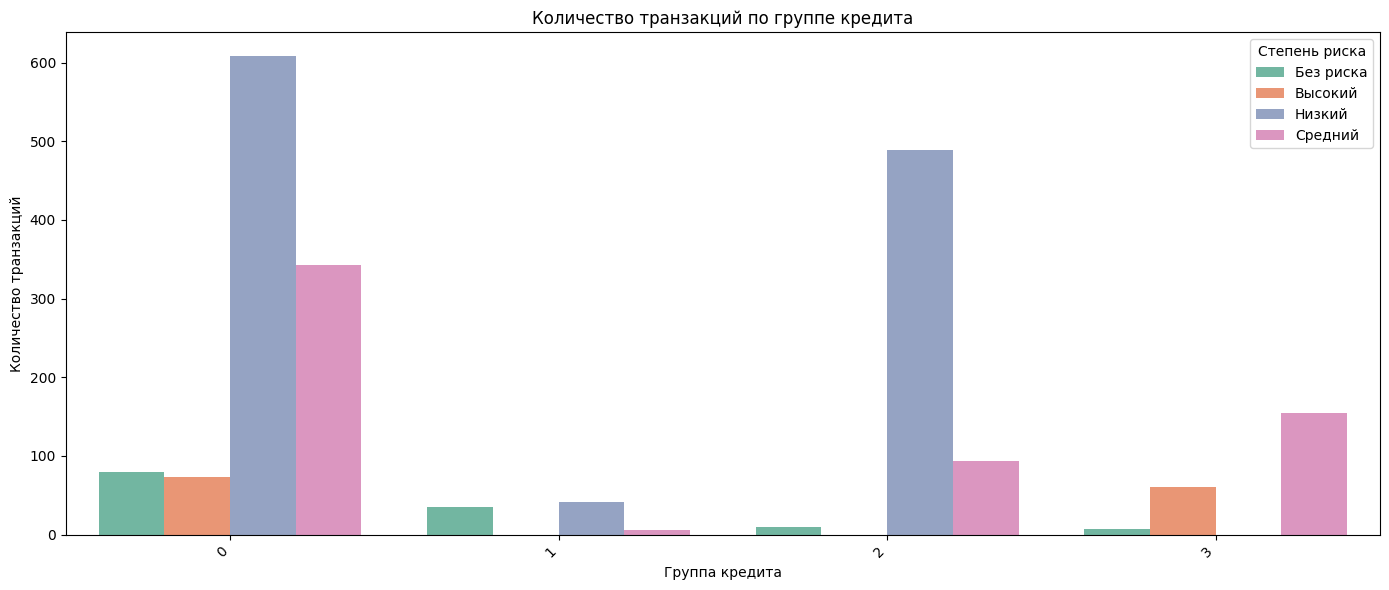

In [31]:
pivot = df.groupby(["credit_group", "Риск"]).size().reset_index(name="count")

# Рисуем группированный столбчатый график
plt.figure(figsize=(14,6))
sns.barplot(data=pivot, x="credit_group", y="count", hue="Риск", palette="Set2")

plt.title("Количество транзакций по группе кредита")
plt.xlabel("Группа кредита")
plt.ylabel("Количество транзакций")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Степень риска")
plt.tight_layout()
plt.show()

In [35]:
keyword_to_group = {
    "зарплата": "salary",
    "коммунальные": "utilities",
    "интернет": "utilities",
    "договор": "contract",
    "счет-фактура": "invoice",
    "ТТН": "invoice",
    "крипто": "crypto",
    "займ": "loan",
    "внутренний": "internal",
    "перевод": "internal",
    "поставки": "supplier",
    "услуги": "supplier",
}

# Функция для определения групп, найденных в тексте
def assign_purpose_group_by_category(text):
    text_lower = str(text).lower()
    found_groups = set()
    
    for word, group in keyword_to_group.items():
        if word in text_lower:
            found_groups.add(group)
    
    if len(found_groups) == 0:
        return "other"
    elif len(found_groups) == 1:
        return list(found_groups)[0]  # единственная группа
    else:
        # если несколько разных групп → количество групп
        return f"{len(found_groups)}_groups"    # несколько слов → special group

# Создаём колонку с группой назначения платежа
df["purpose_group"] = df["Назначение платежа (детали)"].apply(assign_purpose_group_by_category)

df.head()

,Дата проводки,Счёт (наименование + ИНН),Сумма по дебету (RUB),Сумма по кредиту (RUB),Банк (условный БИК + наименование),Назначение платежа (детали),Риск,Причины_оценки_риска,entity_type,debit_group,credit_group,purpose_group
0,2025-08-01 08:09:36,"ООО ТРАНСЛАЙН, ИНН: 1322002203",263316.77,NaN,"Россельхозбанк, г. Москва (БИК: 044525100)",Оплата по договор №392/2025 от 01.06.2025; сче...,Низкий,supplier_with_docs_amount_ok,ООО,2,0,3_groups
1,2025-08-01 08:42:55,"ИП СИДОРОВ В.П., ИНН: 6606007006",NaN,85912.24,"Россельхозбанк, г. Москва (БИК: 044525100)","Перечисление заработной платы, период: 08.2025...",Низкий,default_low,ИП,0,2,other
2,2025-08-01 09:10:22,"ООО БЛЭКХОЛД, ИНН: 2029002900",36635.96,NaN,"ВТБ, г. Москва, Головной офис (БИК: 040349700)",Оплата по договор №798/2025 от 17.06.2025; сче...,Низкий,supplier_with_docs_amount_ok,ООО,1,0,3_groups
3,2025-08-01 09:39:30,"ООО НЕОТЕК, ИНН: 1120002001",NaN,349265.15,"Промсвязьбанк, г. Москва (БИК: 044525000)",Оплата по договор №184/2025 от 23.07.2025; сче...,Низкий,supplier_with_docs_amount_ok,ООО,0,2,3_groups
4,2025-08-01 10:13:15,"ООО ПРОВАЙДЕР, ИНН: 2635003506",NaN,49218.76,"Альфа-Банк, г. Москва (БИК: 044030653)",Оплата коммунальных услуг и интернет; период: ...,Без риска,utilities_or_salary_small,ООО,0,1,utilities


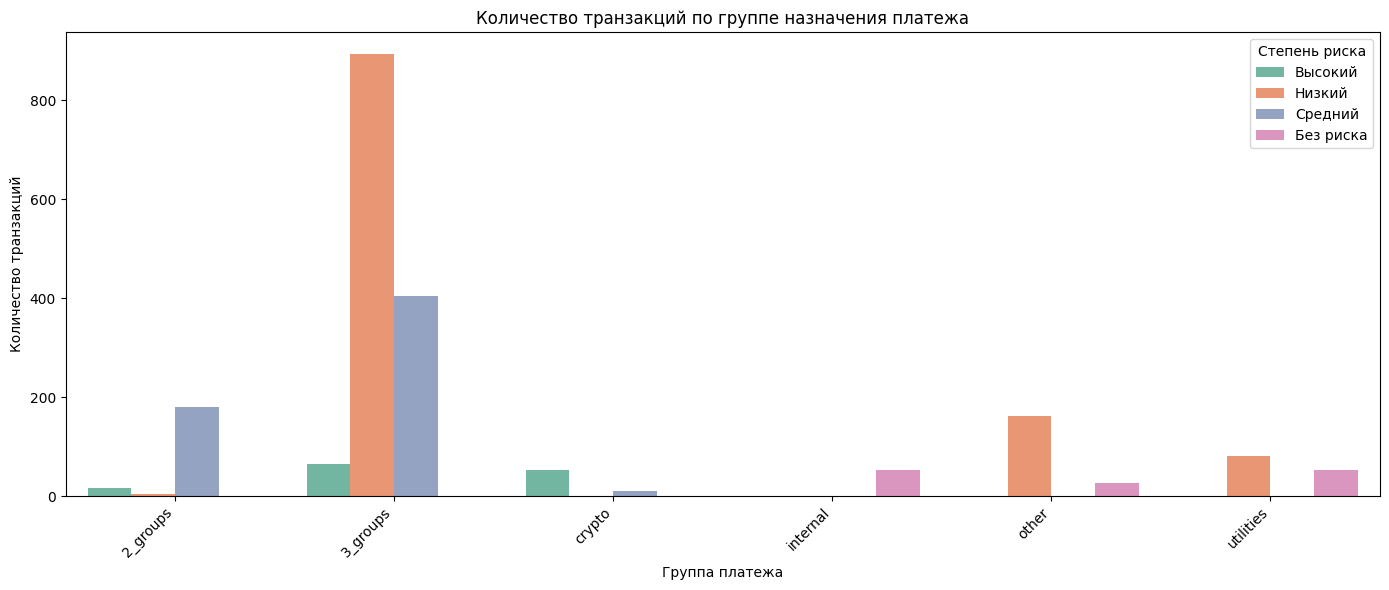

In [36]:
pivot = df.groupby(["purpose_group", "Риск"]).size().reset_index(name="count")

# Рисуем группированный столбчатый график
plt.figure(figsize=(14,6))
sns.barplot(data=pivot, x="purpose_group", y="count", hue="Риск", palette="Set2")

plt.title("Количество транзакций по группе назначения платежа")
plt.xlabel("Группа платежа")
plt.ylabel("Количество транзакций")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Степень риска")
plt.tight_layout()
plt.show()

In [38]:
from collections import Counter
text_column = "Назначение платежа (детали)"

# Объединяем все тексты в один большой
all_text = " ".join(df[text_column].dropna().astype(str).tolist()).lower()

# Разбиваем на слова (только буквы и цифры)
words = re.findall(r"\w+", all_text)

# Считаем частоту каждого слова
word_counts = Counter(words)

# Выводим топ-20 самых частых слов
print(word_counts.most_common(50))

[('2025', 5392), ('оплата', 2923), ('счет', 2886), ('фактура', 2886), ('ттн', 2713), ('08', 2006), ('дата', 2000), ('время', 1669), ('назнач', 1652), ('по', 1564), ('договор', 1536), ('от', 1536), ('09', 1445), ('поставки', 1363), ('проводки', 1363), ('06', 665), ('07', 650), ('аванс', 346), ('16', 335), ('10', 329), ('13', 325), ('18', 322), ('14', 321), ('период', 320), ('20', 314), ('11', 309), ('17', 299), ('19', 299), ('15', 297), ('12', 290), ('перечисление', 251), ('документы', 250), ('услуг', 197), ('заработной', 187), ('платы', 187), ('ведомость', 187), ('сопроводительные', 186), ('отсутствуют', 186), ('23', 178), ('27', 172), ('21', 171), ('02', 166), ('25', 166), ('28', 162), ('03', 158), ('22', 156), ('04', 153), ('24', 151), ('05', 146), ('26', 137)]


In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# -------------------------------
# 2. Выбираем признаки
# -------------------------------
features = ["entity_type", "debit_group", "credit_group", "purpose_group"]
target = "Риск"

# Заполняем пропуски
df[features] = df[features].fillna("NA")

# -------------------------------
# 3. Кодируем категориальные признаки
# -------------------------------
X_encoded = pd.DataFrame()
encoders = {}
for col in features:
    if df[col].dtype == "object":
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(df[col])
        encoders[col] = le
    else:
        X_encoded[col] = df[col]

# Целевая переменная
le_target = LabelEncoder()
y = le_target.fit_transform(df[target])

# -------------------------------
# 4. Делим на train/test
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# 5. Балансировка классов с помощью SMOTE
# -------------------------------
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Размеры после балансировки:")
print(pd.Series(y_train_res).value_counts())

# -------------------------------
# 6. Определяем модели
# -------------------------------
models = {
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
     "LinearSVC": LinearSVC(max_iter=5000, random_state=42),
    "KNeighbors": KNeighborsClassifier(n_neighbors=5)
}

# -------------------------------
# 7. Обучаем и оцениваем модели
# -------------------------------
for name, model in models.items():
    print(f"\n=== Модель: {name} ===")
    
    if name == "CatBoost":
        cat_features = [X_encoded.columns.get_loc(c) for c in X_encoded.columns if df[c].dtype == "object"]
        train_pool = Pool(X_train_res, y_train_res, cat_features=cat_features)
        test_pool = Pool(X_test, y_test, cat_features=cat_features)
        model.fit(train_pool)
        y_pred = model.predict(test_pool)
    else:
        model.fit(X_train_res, y_train_res)
        y_pred = model.predict(X_test)
    
    # Метрики
    print("Classification report:")
    print(classification_report(y_test, y_pred, target_names=le_target.classes_))
    
    print("Confusion matrix:")
    print(confusion_matrix(y_test, y_pred))


Размеры после балансировки:
3    911
1    911
2    911
0    911
Name: count, dtype: int64

=== Модель: RandomForest ===
Classification report:
              precision    recall  f1-score   support

   Без риска       1.00      1.00      1.00        26
     Высокий       0.42      0.59      0.49        27
      Низкий       0.90      0.99      0.94       228
     Средний       0.84      0.60      0.70       119

    accuracy                           0.84       400
   macro avg       0.79      0.79      0.78       400
weighted avg       0.85      0.84      0.84       400

Confusion matrix:
[[ 26   0   0   0]
 [  0  16   0  11]
 [  0   0 225   3]
 [  0  22  26  71]]

=== Модель: XGBoost ===


/Users/stanislav/Documents/Work/bank_agent/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [13:39:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification report:
              precision    recall  f1-score   support

   Без риска       1.00      1.00      1.00        26
     Высокий       0.42      0.59      0.49        27
      Низкий       0.90      0.99      0.94       228
     Средний       0.84      0.60      0.70       119

    accuracy                           0.84       400
   macro avg       0.79      0.79      0.78       400
weighted avg       0.85      0.84      0.84       400

Confusion matrix:
[[ 26   0   0   0]
 [  0  16   0  11]
 [  0   0 225   3]
 [  0  22  26  71]]

=== Модель: LinearSVC ===
Classification report:
              precision    recall  f1-score   support

   Без риска       0.27      0.77      0.40        26
     Высокий       0.24      0.74      0.36        27
      Низкий       0.85      0.75      0.79       228
     Средний       0.76      0.26      0.39       119

    accuracy                           0.60       400
   macro avg       0.53      0.63      0.48       400
weighted avg     

In [50]:
!pip install catboost --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 9.0 MB/s  0:00:03 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 6.9 MB/s  0:00:01 eta 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [catboost]2/4 [plotly]
